In [1]:
!nvidia-smi

Fri Apr 18 02:39:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Introduction

This machine learning pipeline is designed to predict severe traffic accidents (crashes resulting in fatalities or serious injuries) using temporal and seasonal features. The model compares three classification algorithms—Decision Trees, Logistic Regression, and Gaussian Naive Bayes—to determine which best predicts crash severity. Before going into the advance analysis, we would explore data collection from the New York Open Data, do Data Preprocessing, exloratory analysis and Time Series analysis.

The second model used an ARIMA(1, 1, 1) model, a time series forecasting approach that combines autoregression (AR), differencing (I), and moving average (MA) components. This specific ARIMA model is designed to capture patterns in the time series data by including one lag of the dependent variable (AR), differencing the data once (I), and incorporating one lag of the forecast error (MA). The model was applied to a dataset spanning from July 31, 2012, to March 31, 2025, and aimed to predict a continuous dependent variable (y). Key metrics such as the AIC, BIC, and HQIC were used to assess the model's fit, with values indicating a relatively good fit to the data. However, the coefficients for the AR and MA terms are not statistically significant (high p-values), suggesting that the chosen model structure may not fully capture the underlying patterns in the data.

Importing the dataset

In [3]:
import pandas as pd
data = pd.read_csv("/content/Motor_Vehicle_Collisions_-_Crashes_20250323.csv")

<ipython-input-3-4cd44e42b3b8>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/Motor_Vehicle_Collisions_-_Crashes_20250323.csv")


Importing all the libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                           roc_curve, auc, confusion_matrix, classification_report)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import warnings
%matplotlib inline
from matplotlib.pylab import rcParams


Settings

In [5]:
# Set the default figure size for matplotlib plots to 15 inches wide by 6 inches tall
rcParams["figure.figsize"] = (15, 6)

# Increase the default font size of the titles in matplotlib plots to extra-extra-large
rcParams["axes.titlesize"] = "xx-large"

# Make the titles of axes in matplotlib plots bold for better visibility
rcParams["axes.titleweight"] = "bold"

# Set the default location of the legend in matplotlib plots to the upper left corner
rcParams["legend.loc"] = "upper left"

# Configure pandas to display all columns of a DataFrame when printed to the console
pd.set_option('display.max_columns', None)

# Configure pandas to display all rows of a DataFrame when printed to the console
pd.set_option('display.max_rows', None)

Data Collection

In [6]:
data = pd.read_csv("/content/Motor_Vehicle_Collisions_-_Crashes_20250323.csv")

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2163362 entries, 0 to 2163361
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   LOCATION                       object 
 7   ON STREET NAME                 object 
 8   CROSS STREET NAME              object 
 9   OFF STREET NAME                object 
 10  NUMBER OF PERSONS INJURED      float64
 11  NUMBER OF PERSONS KILLED       float64
 12  NUMBER OF PEDESTRIANS INJURED  int64  
 13  NUMBER OF PEDESTRIANS KILLED   int64  
 14  NUMBER OF CYCLIST INJURED      int64  
 15  NUMBER OF CYCLIST KILLED       int64  
 16  NUMBER OF MOTORIST INJURED     int64  
 17  NUMBER OF MOTORIST KILLED      int64  
 18  CO

In [8]:
data.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,2.0,0.0,0,0,0,0,2,0,Aggressive Driving/Road Rage,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,1.0,0.0,0,0,0,0,1,0,Pavement Slippery,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,11/01/2023,1:29,BROOKLYN,11230.0,40.62179,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,1.0,0.0,0,0,0,0,1,0,Unspecified,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN
3,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Following Too Closely,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
4,09/21/2022,13:21,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


In [9]:
data.describe()

,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,COLLISION_ID
count,1.923585e+06,1.923585e+06,2.163344e+06,2.163331e+06,2.163362e+06,2.163362e+06,2.163362e+06,2.163362e+06,2.163362e+06,2.163362e+06,2.163362e+06
mean,4.061364e+01,-7.372655e+01,3.211667e-01,1.550387e-03,5.857411e-02,7.677864e-04,2.802120e-02,1.215700e-04,2.302948e-01,6.328113e-04,3.224514e+06
std,2.118228e+00,3.959941e+00,7.092177e-01,4.152786e-02,2.480441e-01,2.826004e-02,1.671596e-01,1.106706e-02,6.704114e-01,2.750077e-02,1.507577e+06
min,0.000000e+00,-2.013600e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.200000e+01
25%,4.066748e+01,-7.397465e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.176960e+06
50%,4.072045e+01,-7.392698e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.717952e+06
75%,4.076962e+01,-7.386671e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.259020e+06
max,4.334444e+01,0.000000e+00,4.300000e+01,8.000000e+00,2.700000e+01,6.000000e+00,4.000000e+00,2.000000e+00,4.300000e+01,5.000000e+00,4.800167e+06


Checking for Missingness in the data

In [10]:
#TODO: Leverage the isnull() and sum() functions to find the number of missing values in each column
missing_values = data.isnull().sum()

#TODO: Turn the missing value counts into percentages
missing_values_percentage = (missing_values / len(data)) * 100

#TODO: Return counts and percentages of missing values in each column
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage (%)': missing_values_percentage})
missing_data.sort_values(by='Percentage (%)', ascending=False)

,Missing Values,Percentage (%)
VEHICLE TYPE CODE 5,2153953,99.565075
CONTRIBUTING FACTOR VEHICLE 5,2153652,99.551162
VEHICLE TYPE CODE 4,2129095,98.416030
CONTRIBUTING FACTOR VEHICLE 4,2127815,98.356863
VEHICLE TYPE CODE 3,2013230,93.060246
CONTRIBUTING FACTOR VEHICLE 3,2007310,92.786598
OFF STREET NAME,1789754,82.730213
CROSS STREET NAME,825304,38.149140
ZIP CODE,669327,30.939205
BOROUGH,669058,30.926770


The result above shows that there is a lot of data with enormous missing data, however we would be working mostly on the data with less that 18% missing and mostly with no data missing in them.

Explanatory Analysis

In [11]:
# Top contributing factors to crashes
data['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().head(10)

,count
CONTRIBUTING FACTOR VEHICLE 1,
Unspecified,728837
Driver Inattention/Distraction,436718
Failure to Yield Right-of-Way,129223
Following Too Closely,116067
Backing Unsafely,79329
Other Vehicular,67173
Passing or Lane Usage Improper,61438
Passing Too Closely,54574
Turning Improperly,53269


The result above shows that the top contributing factors to crashes are as follows:
"Unspecified" (728,837 cases) being the most common, followed by "Driver Inattention/Distraction" (436,718 cases). Other significant factors include "Failure to Yield Right-of-Way" (129,223), "Following Too Closely" (116,067), and "Backing Unsafely" (79,329).

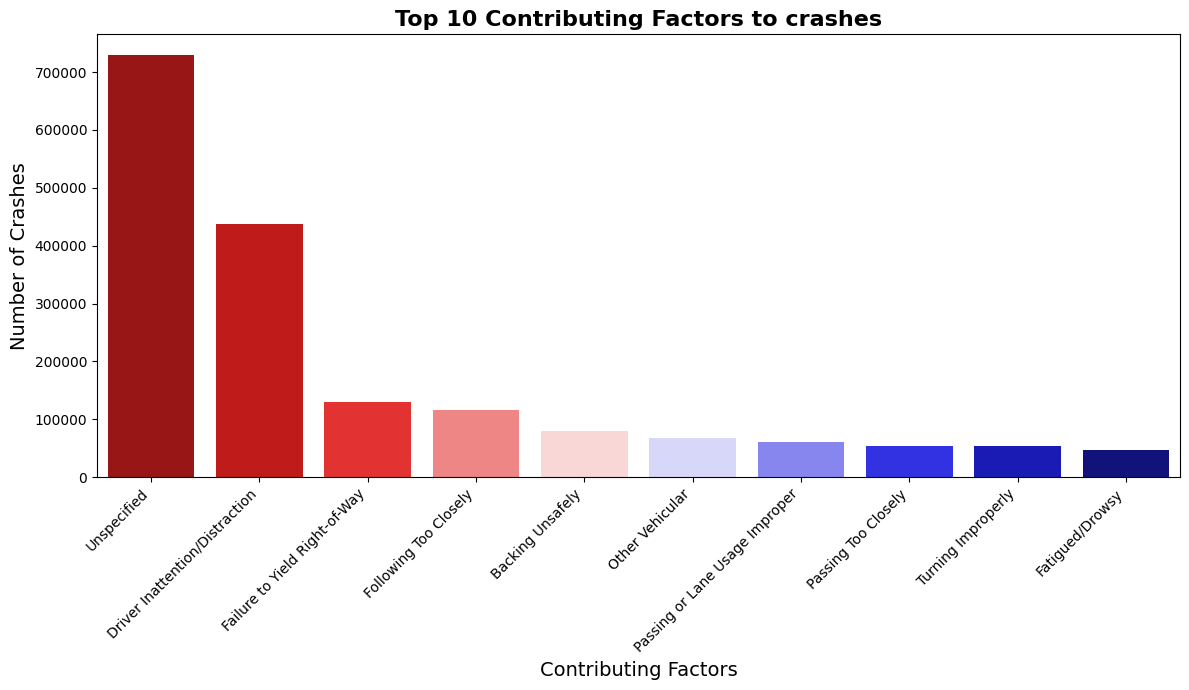

In [12]:
top_factors = data['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().head(10)

plt.figure(figsize=(12, 7))
# TODO: Plotting the top contributing factors
sns.barplot(x=top_factors.index, y=top_factors.values, palette="seismic_r")
plt.title('Top 10 Contributing Factors to crashes', fontsize=16)
plt.xlabel('Contributing Factors', fontsize=14)
plt.ylabel('Number of Crashes', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

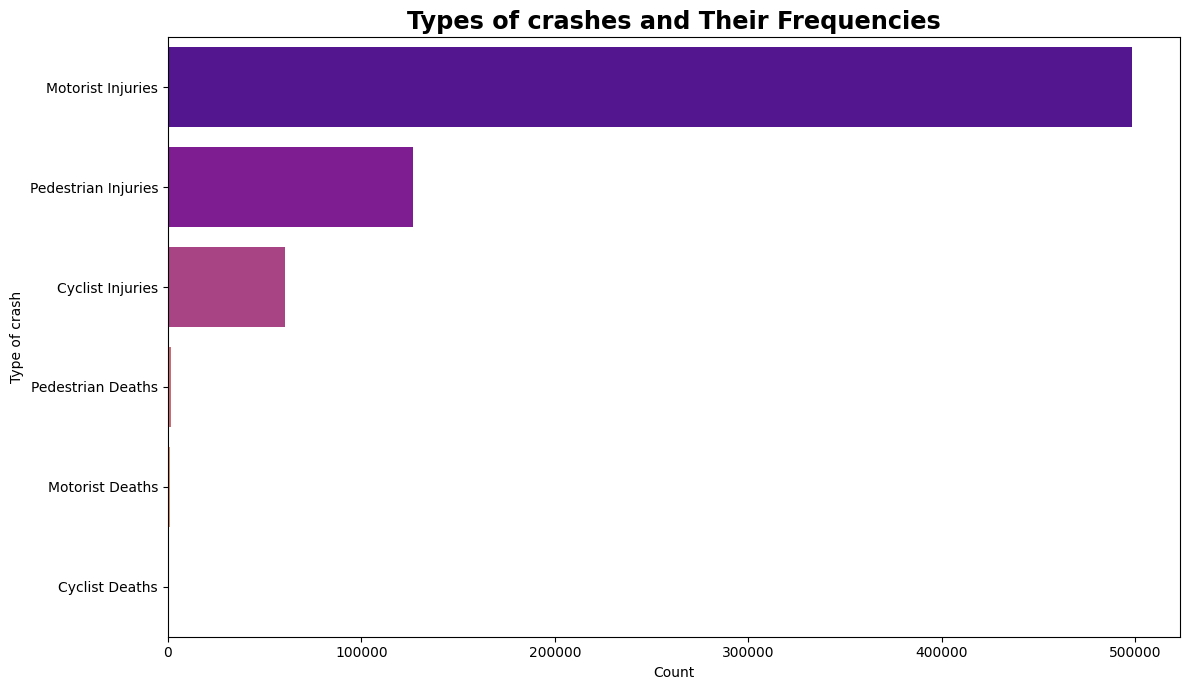

In [13]:
# Aggregating data - Complete for Cyclist and Motorist
types_of_crashes = {
    'Pedestrian Injuries': data['NUMBER OF PEDESTRIANS INJURED'].sum(),
    'Cyclist Injuries': data['NUMBER OF CYCLIST INJURED'].sum(),
    'Motorist Injuries': data['NUMBER OF MOTORIST INJURED'].sum(),
    'Pedestrian Deaths': data['NUMBER OF PEDESTRIANS KILLED'].sum(),
    'Cyclist Deaths': data['NUMBER OF CYCLIST KILLED'].sum(),
    'Motorist Deaths': data['NUMBER OF MOTORIST KILLED'].sum()
}

# Converting to DataFrame for easier plotting - we want the items in the dictionary, use the items function
crash_types_df = pd.DataFrame(list(types_of_crashes.items()), columns=['crash Type', 'Count'])

# Sort the DataFrame by Count in descending order
crash_types_df = crash_types_df.sort_values(by=['Count'], ascending=False)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(x='Count', y='crash Type', data=crash_types_df, palette="plasma")
plt.title('Types of crashes and Their Frequencies')
plt.xlabel('Count')
plt.ylabel('Type of crash')
plt.tight_layout()
plt.show()

The result shows that in New York City, Motorist injuries are the most frequent type of crashes, Pedestrians are second, followed by cyclist injuries, and the crashes that lead to death are very minimal.

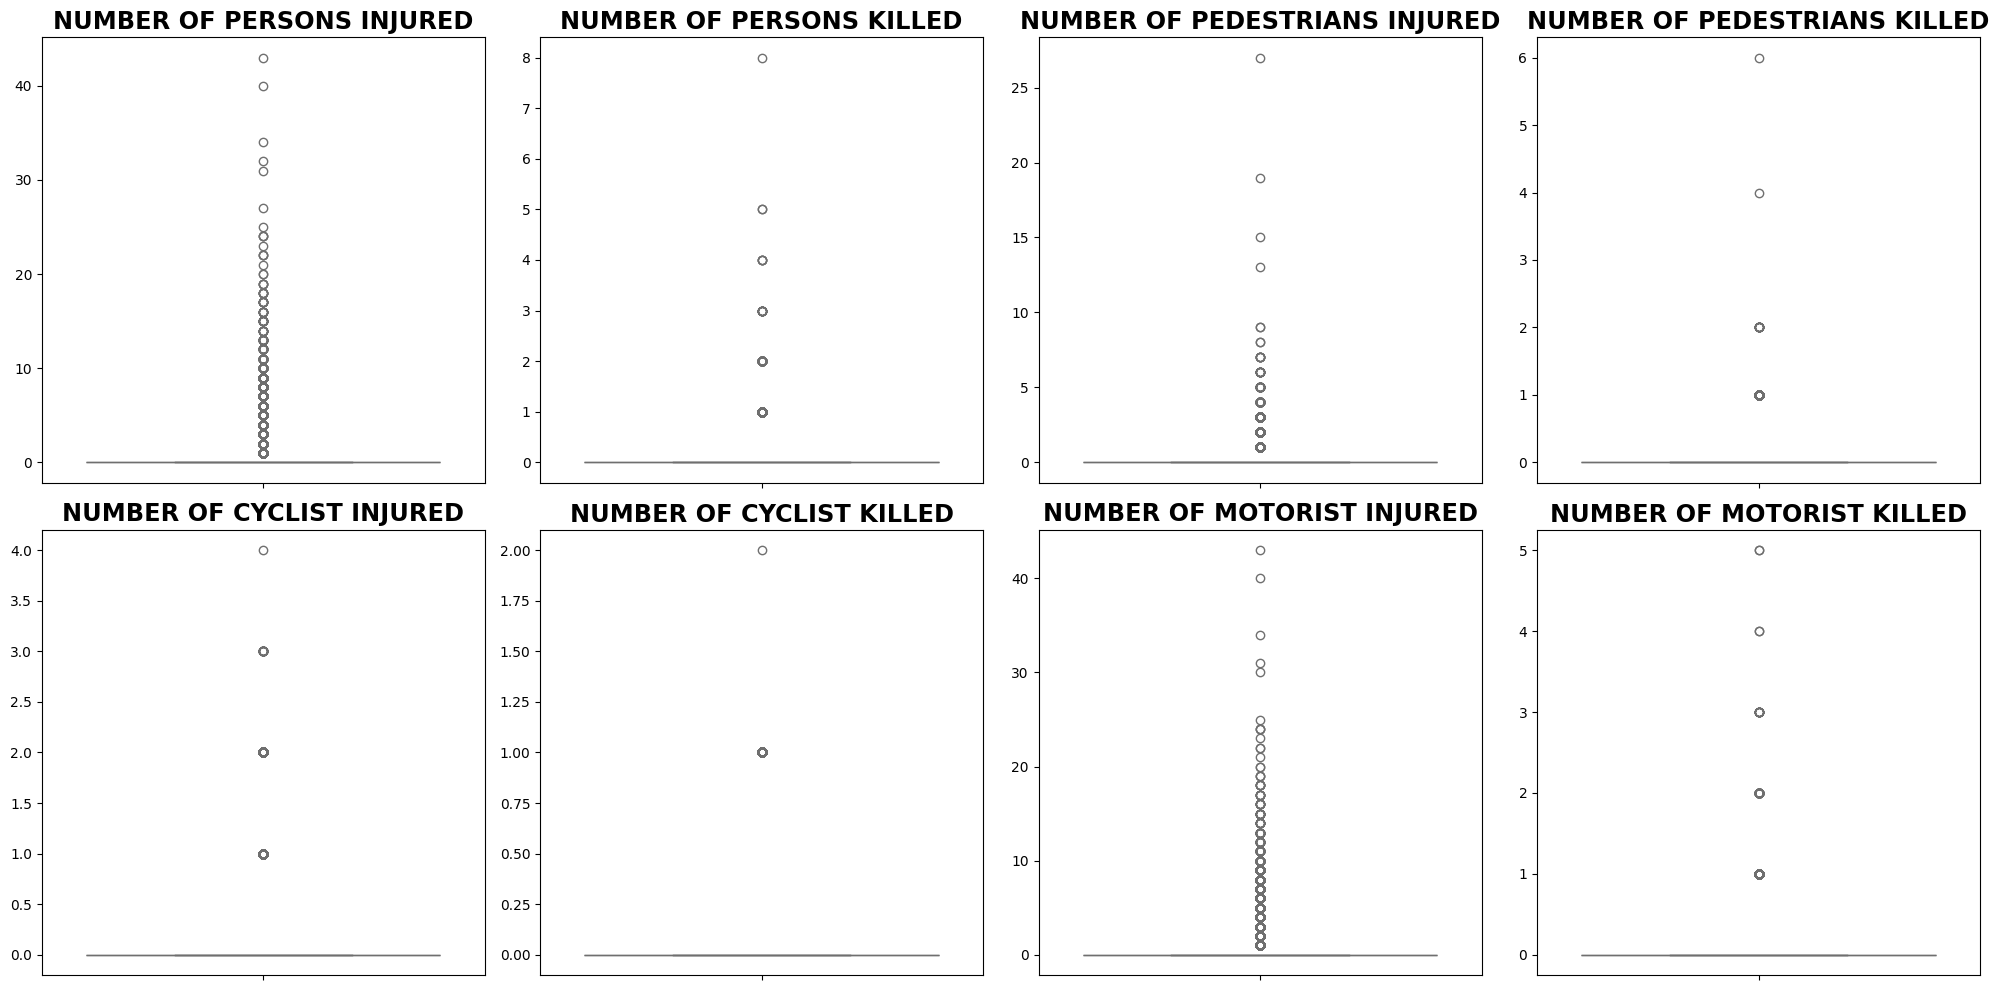

In [16]:
# Create a figure and axes for the subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 4 columns

# List of columns for box plots
cols = [
    'NUMBER OF PERSONS INJURED',
    'NUMBER OF PERSONS KILLED',
    'NUMBER OF PEDESTRIANS INJURED',
    'NUMBER OF PEDESTRIANS KILLED',
    'NUMBER OF CYCLIST INJURED',
    'NUMBER OF CYCLIST KILLED',
    'NUMBER OF MOTORIST INJURED',
    'NUMBER OF MOTORIST KILLED'
]

# Create box plots for each column
for i, col in enumerate(cols):
    row = i // 4  # Determine the row index
    col_index = i % 4  # Determine the column index
    sns.boxplot(y=data[col], ax=axes[row, col_index], color='skyblue')  # Create boxplot
    axes[row, col_index].set_title(col)  # Set the title of the subplot
    axes[row, col_index].set_ylabel('')  # Remove y-axis label for cleaner layout

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

### Data Preprocessing

The traffic crash data is preprocessed in preparation for machine learning or statistical analysis.

The 'CRASH DATE' column is converted into a datetime object and then extracts temporal features from it, such as the day of the week, month, and year. It also creates a new binary a feature called 'IS_WEEKEND' that flags whether a crash occurred on a weekend.

The 'CRASH TIME' column uses a custom function that handles time strings in AM/PM format. Based on the extracted hour, it categorizes the crash into different time periods like "Morning Rush" or "Night" to capture patterns in traffic volume and crash likelihood. Similarly, it creates a 'SEASON' column derived from the month to help uncover seasonal trends in crash occurrences.

The script engineers several binary target variables to aid in classification tasks. These include 'SERIOUS_CRASH', which is flagged when there are fatalities or more than two injuries; 'PEDESTRIAN_INVOLVED' and 'CYCLIST_INVOLVED', which check for the presence of pedestrian or cyclist victims; and 'FATAL_CRASH', which is triggered if any person was killed. These target variables allow the dataset to be used in supervised learning tasks focused on crash severity or the involvement of vulnerable road users.

In [ ]:
# Settings
warnings.filterwarnings('ignore')
np.random.seed(42)

# ====================== DATA PREPROCESSING ======================
print("Starting data preprocessing...")

# Let's assume the data is already loaded into a DataFrame called 'data'
# If you need to load it from a file, uncomment the following line:
# data = pd.read_csv('your_crash_data.csv')

# 1.1 Convert date and time columns to datetime objects
data['CRASH DATE'] = pd.to_datetime(data['CRASH DATE'])

# 1.2 Create useful features from CRASH DATE
data['DAY_OF_WEEK'] = data['CRASH DATE'].dt.dayofweek
data['MONTH'] = data['CRASH DATE'].dt.month
data['YEAR'] = data['CRASH DATE'].dt.year
data['IS_WEEKEND'] = data['DAY_OF_WEEK'].apply(lambda x: 1 if x >= 5 else 0)

# 1.3 Extract hour from CRASH TIME
def extract_hour(time_str):
    try:
        if pd.isna(time_str):
            return np.nan
        parts = time_str.split(':')
        hour = int(parts[0])
        # Check if it's PM and not noon
        if 'PM' in time_str and hour != 12:
            hour += 12
        # Check if it's AM and midnight
        if 'AM' in time_str and hour == 12:
            hour = 0
        return hour
    except:
        return np.nan

# Apply the function to extract hour
data['HOUR'] = data['CRASH TIME'].apply(extract_hour)

# 1.4 Create time period categories
def categorize_time(hour):
    if pd.isna(hour):
        return np.nan
    if 6 <= hour < 10:
        return 'Morning Rush'
    elif 10 <= hour < 16:
        return 'Daytime'
    elif 16 <= hour < 20:
        return 'Evening Rush'
    else:
        return 'Night'

data['TIME_PERIOD'] = data['HOUR'].apply(categorize_time)

# 1.5 Create season categories
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

data['SEASON'] = data['MONTH'].apply(get_season)

# 1.6 Create target variables for classification
# Binary target: Serious crash (killed > 0 or injured > 2)
data['SERIOUS_CRASH'] = ((data['NUMBER OF PERSONS KILLED'] > 0) |
                         (data['NUMBER OF PERSONS INJURED'] > 2)).astype(int)

# Binary target: Pedestrian involved
data['PEDESTRIAN_INVOLVED'] = ((data['NUMBER OF PEDESTRIANS KILLED'] > 0) | \
                              (data['NUMBER OF PEDESTRIANS INJURED'] > 0)).astype(int)

# Binary target: Cyclist involved
data['CYCLIST_INVOLVED'] = ((data['NUMBER OF CYCLIST KILLED'] > 0) | \
                            (data['NUMBER OF CYCLIST INJURED'] > 0)).astype(int)

# Binary target: Fatal crash
data['FATAL_CRASH'] = (data['NUMBER OF PERSONS KILLED'] > 0).astype(int)

### Feature Selection

The target variable defined is for prediction, choosing 'SERIOUS_CRASH' from a set of possible outcomes such as pedestrian or cyclist involvement or fatal crashes. It then selects a subset of relevant features—mostly derived from earlier preprocessing steps—such as day of the week, month, year, whether the crash happened on a weekend, the hour, categorized time period, and season.

These features are used to construct the feature matrix X, while the chosen target column becomes the label vector y, the shapes of X and y, as well as the class distribution in the target, giving insight into class balance before proceeding to modeling.

In [ ]:
# ====================== FEATURE SELECTION ======================
# Choose which target to predict (change this to analyze different outcomes)
TARGET = 'SERIOUS_CRASH'  # Options: 'SERIOUS_CRASH', 'PEDESTRIAN_INVOLVED', 'CYCLIST_INVOLVED', 'FATAL_CRASH'

# Select relevant features
features = [
    'DAY_OF_WEEK', 'MONTH', 'YEAR', 'IS_WEEKEND', 'HOUR',
    'TIME_PERIOD', 'SEASON'
]

# Create X (features) and y (target)
X = data[features].copy()
y = data[TARGET].copy()

print(f"Selected features: {features}")
print(f"Target variable: {TARGET}")
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Class distribution: {y.value_counts().to_dict()}")

### Data Sampling


This section handles data sampling and splitting to prepare for model training and evaluation. First, a smaller subset of 100,000 samples is created from the full dataset using stratified sampling to preserve the original class distribution of the target variable, which is over 400,000.

The full dataset is split into training and testing sets using an 80-20 split, again with stratification to maintain balanced classes across both sets. The resulting shapes and class distributions are printed, providing confirmation that the data is ready for modeling.

In [ ]:
# ====================== DATA SAMPLING ======================
# First, let's create a smaller random sample
# For imbalanced data, we'll use stratified sampling to maintain class distribution
X_sample, _, y_sample, _ = train_test_split(
    X, y,
    train_size=100000,  # Adjust this number based on your available memory
    stratify=y,  # Keep the same class distribution
    random_state=42
)

print(f"\nSampled data - X shape: {X_sample.shape}, y shape: {y_sample.shape}")
print(f"Class distribution in sample: {pd.Series(y_sample).value_counts().to_dict()}")

# ====================== TRAIN-TEST SPLIT ======================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


### Feature processing

This section sets up the preprocessing pipeline to prepare features for machine learning models. It first distinguishes between categorical features ('TIME_PERIOD' and 'SEASON') and numerical features (like 'DAY_OF_WEEK', 'MONTH', 'YEAR', 'IS_WEEKEND', and 'HOUR'). Then, it creates a ColumnTransformer called preprocessor that applies separate pipelines to each type of feature: numerical features are imputed using the median and scaled using standardization, while categorical features are imputed with the most frequent value and then one-hot encoded. This modular setup ensures that all feature types are clean, normalized, and appropriately formatted for use in models.

In [ ]:

# ====================== FEATURE PREPROCESSING ======================
# Identify categorical features and numerical features
categorical_features = ['TIME_PERIOD', 'SEASON']
numerical_features = ['DAY_OF_WEEK', 'MONTH', 'YEAR', 'IS_WEEKEND', 'HOUR']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)


### Creating the model

The create_pipeline function builds a reusable machine learning pipeline that includes both preprocessing (as defined earlier) and a classifier of choice. The evaluate_model function uses stratified **k-fold cross-validation** (**default 5 folds**) to assess the model's performance more robustly. For each fold, it fits the pipeline, makes predictions, and collects key evaluation metrics: **accuracy, weighted F1 score, and ROC AUC. **

Furthermore, it also computes ROC curves for each fold and averages them to create a mean ROC curve with standard deviation, which is useful for visualizing classifier performance. The function finally returns a dictionary containing the mean and standard deviation of each metric across folds, as well as ROC curve data, offering a comprehensive snapshot of the model's predictive power and stability.

In [ ]:

# ====================== MODEL CREATION ======================
def create_pipeline(classifier):
    """Create a pipeline with preprocessing and classifier"""
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

def evaluate_model(pipeline, X, y, cv=5):
    """Evaluate model with stratified cross-validation"""
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    accuracy_scores = []
    f1_scores = []
    roc_auc_scores = []

    # For ROC curve
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(8, 6))

    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_fold_train, X_fold_test = X.iloc[train_idx], X.iloc[test_idx]
        y_fold_train, y_fold_test = y.iloc[train_idx], y.iloc[test_idx]

        # Train the model
        pipeline.fit(X_fold_train, y_fold_train)

        # Predict and evaluate
        y_pred = pipeline.predict(X_fold_test)
        y_proba = pipeline.predict_proba(X_fold_test)[:, 1]

        # Calculate metrics
        accuracy_scores.append(accuracy_score(y_fold_test, y_pred))
        f1_scores.append(f1_score(y_fold_test, y_pred, average='weighted'))
        roc_auc_scores.append(roc_auc_score(y_fold_test, y_proba))

        # Calculate ROC curve for this fold
        fpr, tpr, _ = roc_curve(y_fold_test, y_proba)

        # Interpolate TPR at set FPR points for averaging
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))

    # Calculate and plot the mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    results = {
        'accuracy': {
            'mean': np.mean(accuracy_scores),
            'std': np.std(accuracy_scores)
        },
        'f1': {
            'mean': np.mean(f1_scores),
            'std': np.std(f1_scores)
        },
        'roc_auc': {
            'mean': np.mean(roc_auc_scores),
            'std': np.std(roc_auc_scores)
        },
        'roc_data': {
            'mean_fpr': mean_fpr,
            'mean_tpr': mean_tpr,
            'mean_auc': mean_auc,
            'std_auc': std_auc
        }
    }

    return results


### Model Training and Hyperparameter Tuning

Initializes three different classification models—Decision Tree, Logistic Regression, and Gaussian Naive Bayes—and wraps each one into a pipeline using the previously defined create_pipeline function. This setup ensures that each model is trained on consistently preprocessed data, which includes both scaling and encoding.

This section performs hyperparameter tuning for the Decision Tree and Logistic Regression models using GridSearchCV with 5-fold cross-validation, optimizing for the weighted F1 score. For the Decision Tree, it explores combinations of parameters like max_depth, min_samples_split, min_samples_leaf, and criterion. For Logistic Regression, it tests different values of the regularization strength C, solver types, and whether to apply class weighting. The best-performing parameter sets are selected, and the corresponding optimized pipelines (dt_best_pipeline and lr_best_pipeline) are saved for later evaluation

In [ ]:

# ====================== MODEL TRAINING ======================
print("\nTraining and evaluating models...")

# 6.1 Decision Tree
dt_clf = DecisionTreeClassifier(random_state=42)
dt_pipeline = create_pipeline(dt_clf)

# 6.2 Logistic Regression
lr_clf = LogisticRegression(random_state=42, max_iter=1000)
lr_pipeline = create_pipeline(lr_clf)

# 6.3 Gaussian Naive Bayes
gnb_clf = GaussianNB()
gnb_pipeline = create_pipeline(gnb_clf)


In [ ]:

# ====================== HYPERPARAMETER TUNING ======================
print("\nPerforming hyperparameter tuning...")

# 7.1 Grid Search for Decision Tree
dt_param_grid = {
    'classifier__max_depth': [None, 5, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

dt_grid = GridSearchCV(
    dt_pipeline, dt_param_grid, cv=5, scoring='f1_weighted', n_jobs=1  # Changed to 1
)
dt_grid.fit(X_train, y_train)
dt_best_pipeline = dt_grid.best_estimator_

# 7.2 Grid Search for Logistic Regression
lr_param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'liblinear'],
    'classifier__class_weight': [None, 'balanced']
}

lr_grid = GridSearchCV(
    lr_pipeline, lr_param_grid, cv=5, scoring='f1_weighted', n_jobs=1  # Changed to 1
)
lr_grid.fit(X_train, y_train)
lr_best_pipeline = lr_grid.best_estimator_

print(f"Best Logistic Regression parameters: {lr_grid.best_params_}")
print(f"Best Logistic Regression F1 score: {lr_grid.best_score_:.4f}")


In [ ]:

# ====================== MODEL EVALUATION ======================
print("\nEvaluating models with 5-fold cross-validation...")

# 8.1 Evaluate Decision Tree (best model)
dt_results = evaluate_model(dt_best_pipeline, X_train, y_train)

# 8.2 Evaluate Logistic Regression (best model)
lr_results = evaluate_model(lr_best_pipeline, X_train, y_train)

# 8.3 Evaluate Gaussian Naive Bayes
gnb_results = evaluate_model(gnb_pipeline, X_train, y_train)

# 9. Display Cross-Validation Results
print("\n===== Cross-Validation Results =====")

models = ['Decision Tree', 'Logistic Regression', 'Gaussian Naive Bayes']
results = [dt_results, lr_results, gnb_results]
metrics = ['accuracy', 'f1', 'roc_auc']

# Create a DataFrame for better visualization
results_df = pd.DataFrame(index=models, columns=[
    'Accuracy (mean)', 'Accuracy (std)',
    'F1 Score (mean)', 'F1 Score (std)',
    'AUC-ROC (mean)', 'AUC-ROC (std)'
])

for i, model_name in enumerate(models):
    results_df.loc[model_name, 'Accuracy (mean)'] = results[i]['accuracy']['mean']
    results_df.loc[model_name, 'Accuracy (std)'] = results[i]['accuracy']['std']
    results_df.loc[model_name, 'F1 Score (mean)'] = results[i]['f1']['mean']
    results_df.loc[model_name, 'F1 Score (std)'] = results[i]['f1']['std']
    results_df.loc[model_name, 'AUC-ROC (mean)'] = results[i]['roc_auc']['mean']
    results_df.loc[model_name, 'AUC-ROC (std)'] = results[i]['roc_auc']['std']

print(results_df)


#Model Evaluation
Evaluates the trained models using 5-fold stratified cross-validation on the training set. It assumes that dt_best_pipeline and lr_best_pipeline refer to tuned or selected versions of the Decision Tree and Logistic Regression models, respectively, while Gaussian Naive Bayes is evaluated as-is. The evaluation collects accuracy, F1 score, and ROC AUC for each fold and computes their mean and standard deviation.

In [ ]:

# ====================== TEST SET EVALUATION ======================
print("\nRetraining on full training set and evaluating on test set...")

# 10.1 Decision Tree
dt_best_pipeline.fit(X_train, y_train)
dt_test_pred = dt_best_pipeline.predict(X_test)
dt_test_proba = dt_best_pipeline.predict_proba(X_test)[:, 1]

# 10.2 Logistic Regression
lr_best_pipeline.fit(X_train, y_train)
lr_test_pred = lr_best_pipeline.predict(X_test)
lr_test_proba = lr_best_pipeline.predict_proba(X_test)[:, 1]

# 10.3 Gaussian Naive Bayes
gnb_pipeline.fit(X_train, y_train)
gnb_test_pred = gnb_pipeline.predict(X_test)
gnb_test_proba = gnb_pipeline.predict_proba(X_test)[:, 1]

# 11. Calculate test set metrics
print("\n===== Test Set Performance =====")

test_results = pd.DataFrame(index=models, columns=['Accuracy', 'F1 Score', 'AUC-ROC'])

# Decision Tree
test_results.loc['Decision Tree', 'Accuracy'] = accuracy_score(y_test, dt_test_pred)
test_results.loc['Decision Tree', 'F1 Score'] = f1_score(y_test, dt_test_pred, average='weighted')
test_results.loc['Decision Tree', 'AUC-ROC'] = roc_auc_score(y_test, dt_test_proba)

# Logistic Regression
test_results.loc['Logistic Regression', 'Accuracy'] = accuracy_score(y_test, lr_test_pred)
test_results.loc['Logistic Regression', 'F1 Score'] = f1_score(y_test, lr_test_pred, average='weighted')
test_results.loc['Logistic Regression', 'AUC-ROC'] = roc_auc_score(y_test, lr_test_proba)

# Gaussian Naive Bayes
test_results.loc['Gaussian Naive Bayes', 'Accuracy'] = accuracy_score(y_test, gnb_test_pred)
test_results.loc['Gaussian Naive Bayes', 'F1 Score'] = f1_score(y_test, gnb_test_pred, average='weighted')
test_results.loc['Gaussian Naive Bayes', 'AUC-ROC'] = roc_auc_score(y_test, gnb_test_proba)

print(test_results)


In [ ]:
# ====================== VISUALIZATIONS ======================
# 12. Plot ROC Curves
plt.figure(figsize=(10, 8))

# Decision Tree ROC from cross-validation
plt.plot(
    dt_results['roc_data']['mean_fpr'],
    dt_results['roc_data']['mean_tpr'],
    label=f'Decision Tree (AUC = {dt_results["roc_data"]["mean_auc"]:.3f} ± {dt_results["roc_data"]["std_auc"]:.3f})',
    color='blue', linestyle='-', linewidth=2
)

# Logistic Regression ROC from cross-validation
plt.plot(
    lr_results['roc_data']['mean_fpr'],
    lr_results['roc_data']['mean_tpr'],
    label=f'Logistic Regression (AUC = {lr_results["roc_data"]["mean_auc"]:.3f} ± {lr_results["roc_data"]["std_auc"]:.3f})',
    color='red', linestyle='-', linewidth=2
)

# Gaussian Naive Bayes ROC from cross-validation
plt.plot(
    gnb_results['roc_data']['mean_fpr'],
    gnb_results['roc_data']['mean_tpr'],
    label=f'Gaussian Naive Bayes (AUC = {gnb_results["roc_data"]["mean_auc"]:.3f} ± {gnb_results["roc_data"]["std_auc"]:.3f})',
    color='green', linestyle='-', linewidth=2
)

# Add chance line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves for {TARGET} Classification (Cross-Validation)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig('roc_curves_cv.png')
plt.close()



### Further Diagnose

Each model's performance is visualized with a colored line labeled with its corresponding AUC (Area Under the Curve) score, offering a clear comparison of their ability to distinguish between classes. A diagonal dashed line represents random guessing, serving as a baseline.

In [ ]:
# 13. Test Set ROC Curves
plt.figure(figsize=(10, 8))

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_test_proba)
roc_auc_dt = auc(fpr_dt, tpr_dt)
plt.plot(fpr_dt, tpr_dt, color='blue', lw=2,
         label=f'Decision Tree (AUC = {roc_auc_dt:.3f})')

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_test_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, color='red', lw=2,
         label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})')

# Gaussian Naive Bayes
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, gnb_test_proba)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)
plt.plot(fpr_gnb, tpr_gnb, color='green', lw=2,
         label=f'Gaussian Naive Bayes (AUC = {roc_auc_gnb:.3f})')

# Add chance line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves for {TARGET} Classification (Test Set)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig('roc_curves_test.png')
plt.close()


#Feature Importance

These matrices help to clearly show the counts of true positives, false positives, true negatives, and false negatives for each classifier. Following this, classification reports are printed to the console, detailing precision, recall, F1-score, and support for each class

In [ ]:
# ====================== FEATURE IMPORTANCE ======================
# 14. Feature Importance Analysis
# For Decision Tree
if hasattr(dt_best_pipeline.named_steps['classifier'], 'feature_importances_'):
    # Get feature names from preprocessor
    cat_features = dt_best_pipeline.named_steps['preprocessor'].transformers_[1][2]
    num_features = dt_best_pipeline.named_steps['preprocessor'].transformers_[0][2]
    ohe = dt_best_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']

    # Get all transformed feature names
    cat_feature_names = ohe.get_feature_names_out(cat_features)
    feature_names = np.append(num_features, cat_feature_names)

    # Get feature importances
    importances = dt_best_pipeline.named_steps['classifier'].feature_importances_

    # Create DataFrame for visualization
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Decision Tree Feature Importances')
    plt.tight_layout()
    plt.savefig('feature_importances.png')
    plt.close()

    print("\nTop 10 most important features:")
    print(feature_importance.head(10))


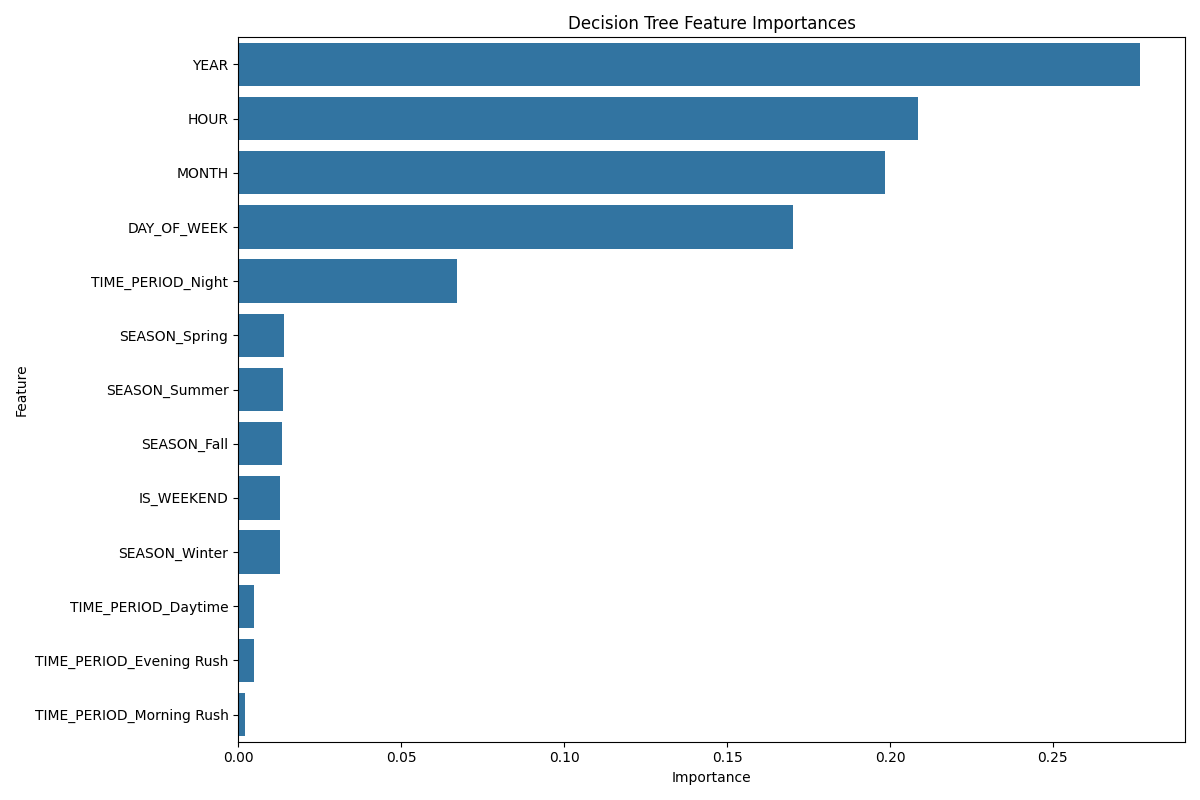

Starting data preprocessing...
Selected features: ['DAY_OF_WEEK', 'MONTH', 'YEAR', 'IS_WEEKEND', 'HOUR', 'TIME_PERIOD', 'SEASON']
Target variable: SERIOUS_CRASH
X shape: (2163362, 7), y shape: (2163362,)
Class distribution: {0: 2120534, 1: 42828}

Sampled data - X shape: (100000, 7), y shape: (100000,)
Class distribution in sample: {0: 98020, 1: 1980}

Training set: 1730689 samples
Test set: 432673 samples

Training and evaluating models...

Performing hyperparameter tuning...
Best Logistic Regression parameters: {'classifier__C': 0.001, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best Logistic Regression F1 score: 0.9704

Evaluating models with 5-fold cross-validation...

===== Cross-Validation Results =====
                     Accuracy (mean) Accuracy (std) F1 Score (mean)  \
Decision Tree               0.980203       0.000001        0.970404   
Logistic Regression         0.980203       0.000001        0.970404   
Gaussian Naive Bay

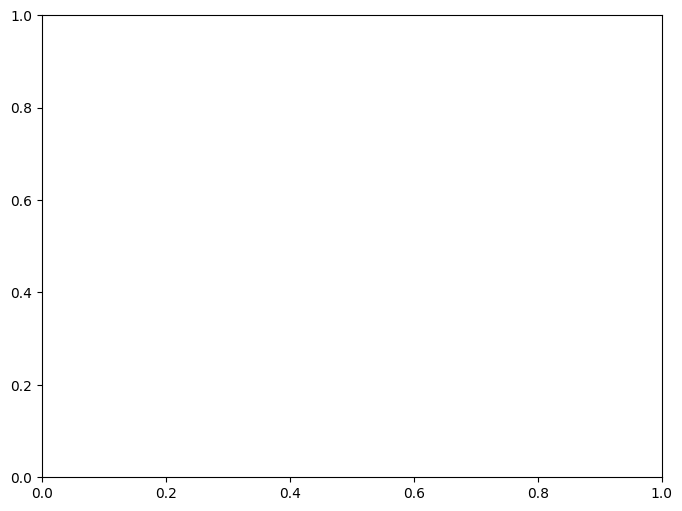

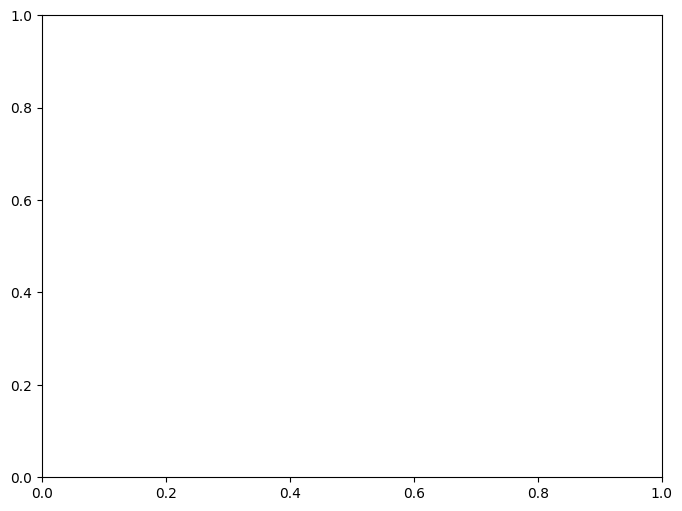

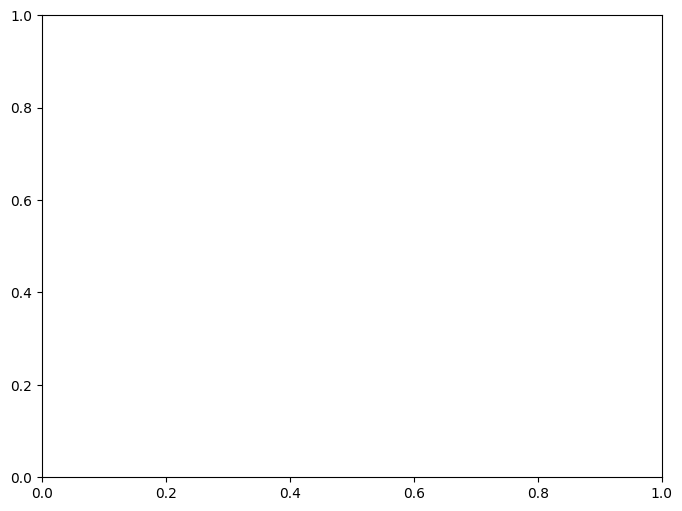

In [4]:
# ====================== CONFUSION MATRICES ======================
# 15. Confusion Matrices
# Decision Tree
dt_cm = confusion_matrix(y_test, dt_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('dt_confusion_matrix.png')
plt.close()

# Logistic Regression
lr_cm = confusion_matrix(y_test, lr_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('lr_confusion_matrix.png')
plt.close()

# Gaussian Naive Bayes
gnb_cm = confusion_matrix(y_test, gnb_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(gnb_cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Gaussian Naive Bayes Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('gnb_confusion_matrix.png')
plt.close()

# ====================== FINAL REPORTS ======================
# 16. Classification Reports
print("\n===== Classification Reports =====")

print("\nDecision Tree:")
print(classification_report(y_test, dt_test_pred))

print("\nLogistic Regression:")
print(classification_report(y_test, lr_test_pred))

print("\nGaussian Naive Bayes:")
print(classification_report(y_test, gnb_test_pred))

print("\nAnalysis complete!")

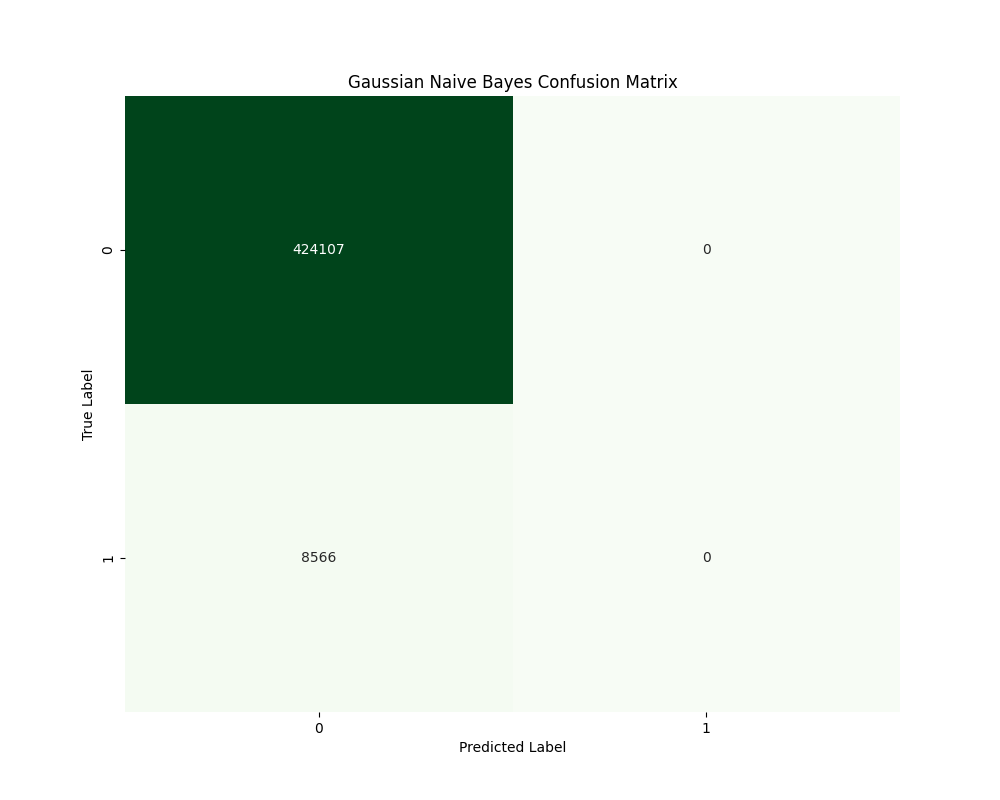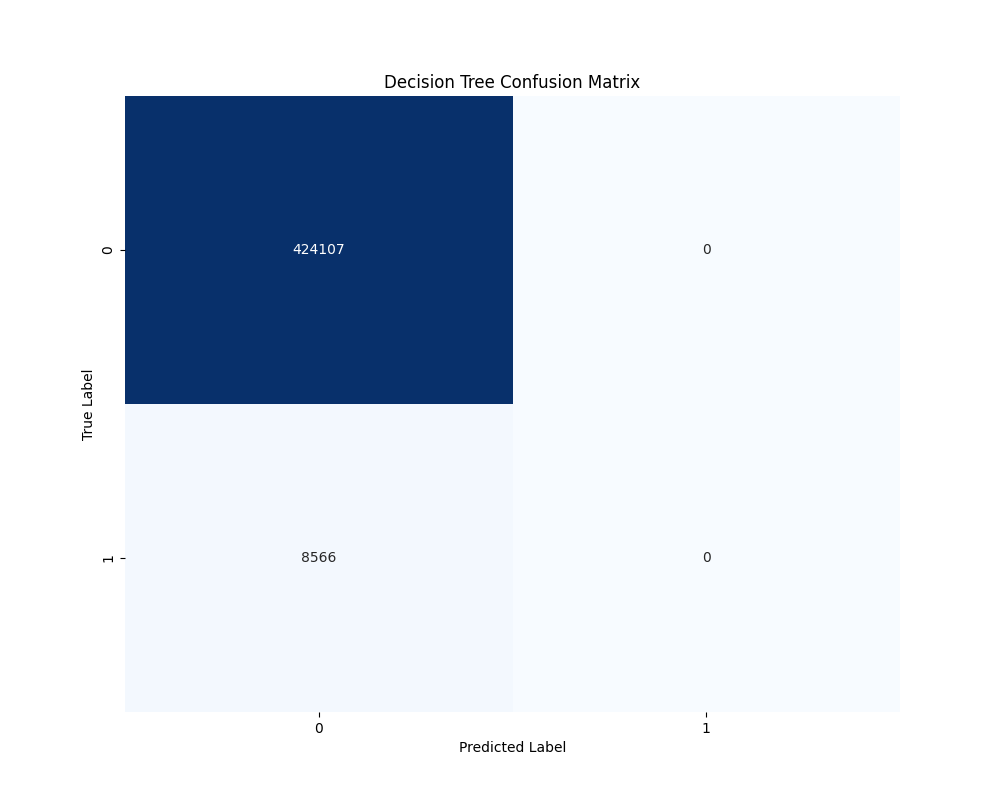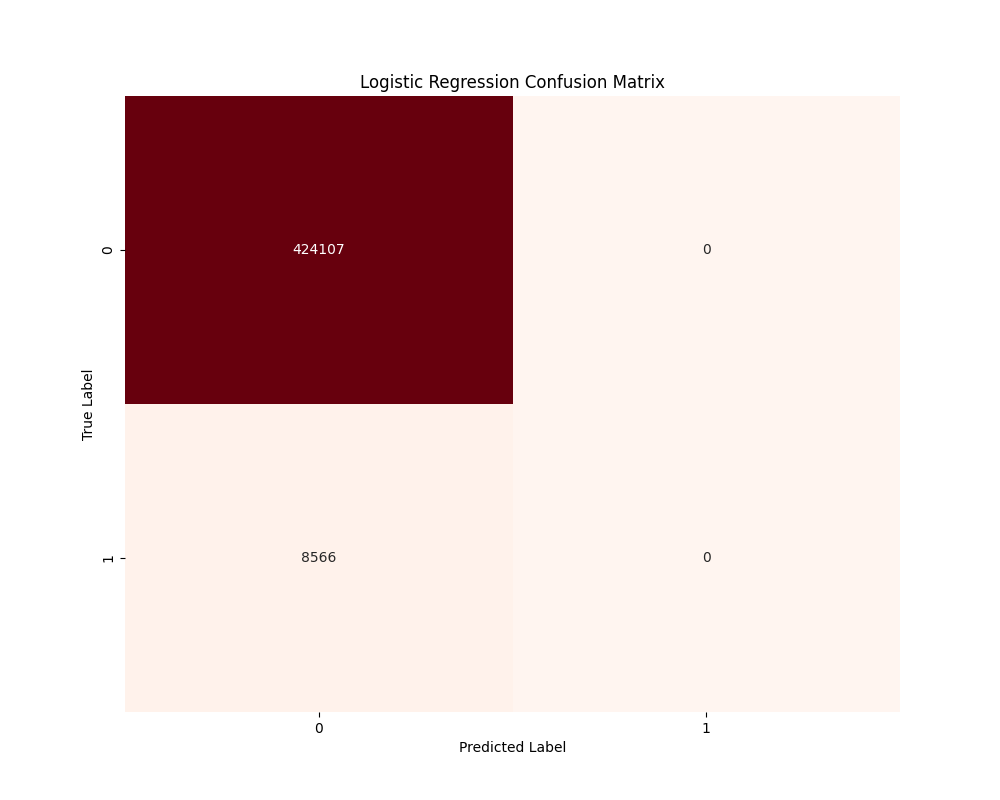

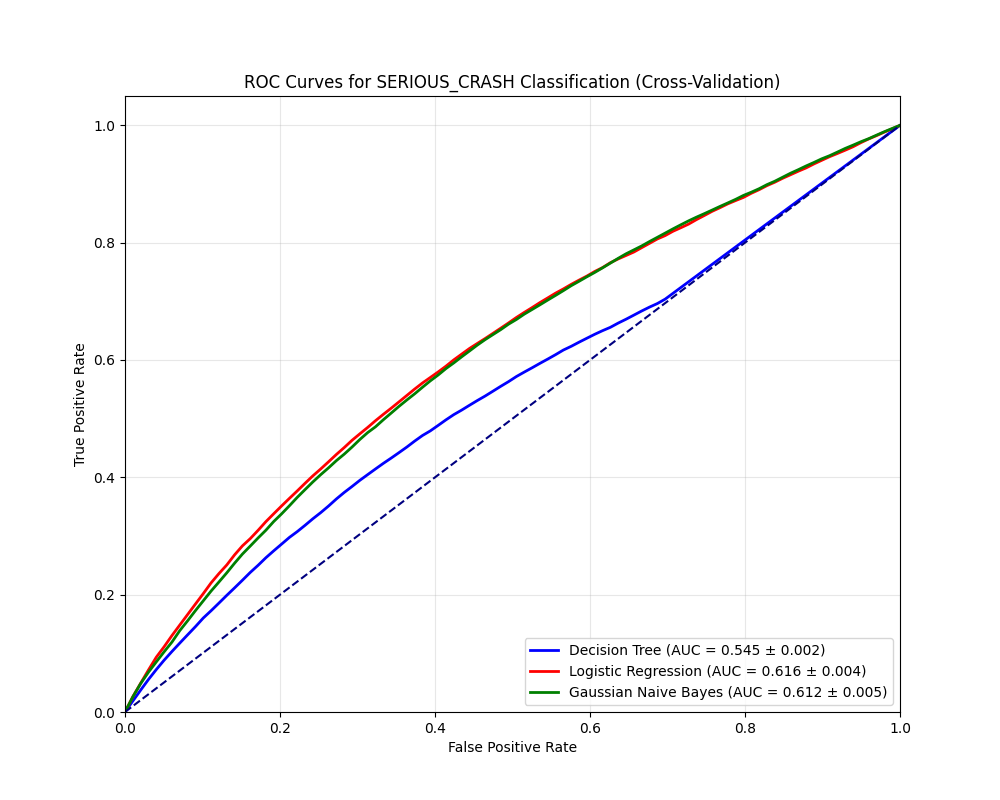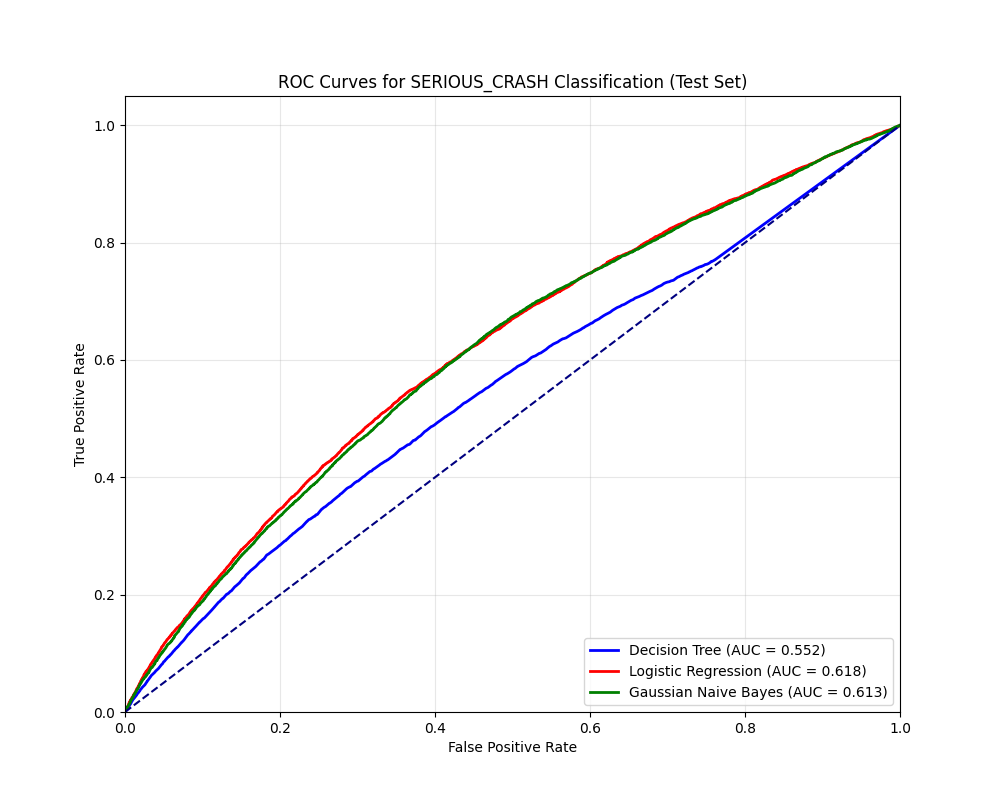

### Second Model

The ARIMA(1,1,1) model was applied to time series data (July 2012–March 2025) to forecast a continuous variable, combining autoregressive and moving average components with first-order differencing. While the model showed adequate fit (AIC/BIC/HQIC) and no residual autocorrelation (Ljung-Box p=0.51), its AR/MA terms lacked statistical significance, and high prediction errors (MSE=2.46M, RMSE=1,567, MAE=1,230) revealed limited accuracy. Additionally, non-normal residuals (Jarque-Bera) and heteroskedasticity (p=0.01) indicate unresolved volatility patterns, suggesting the model partially captures temporal dependencies but requires refinement for better performance.

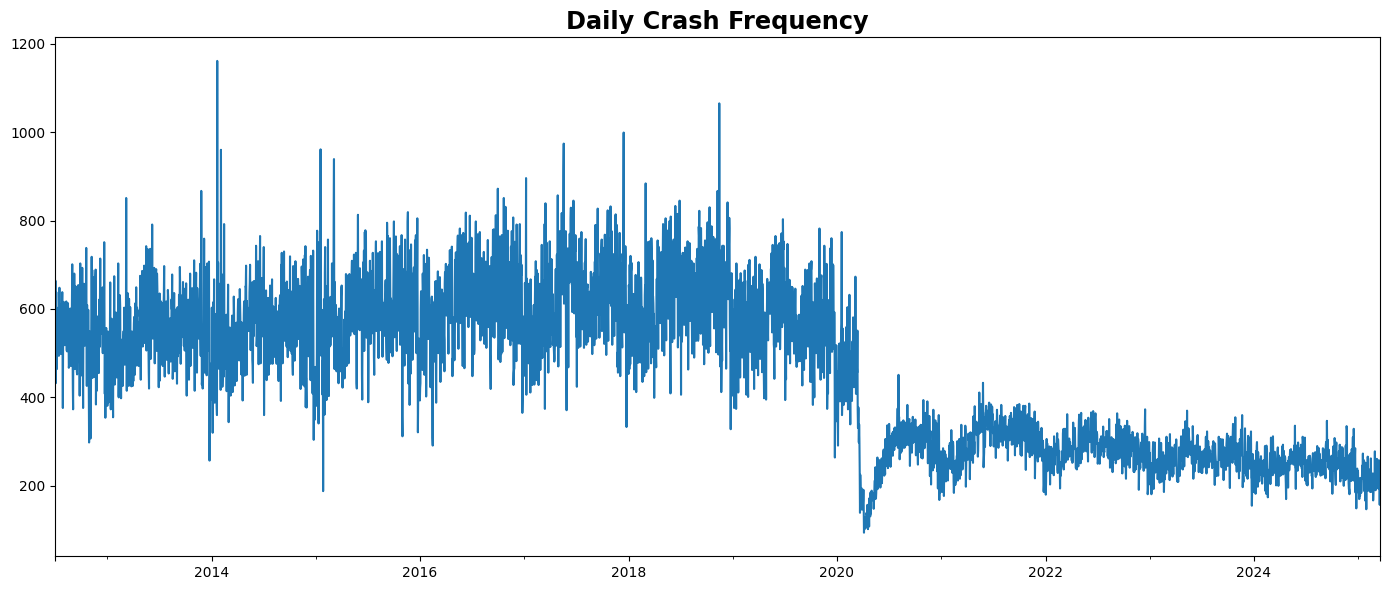

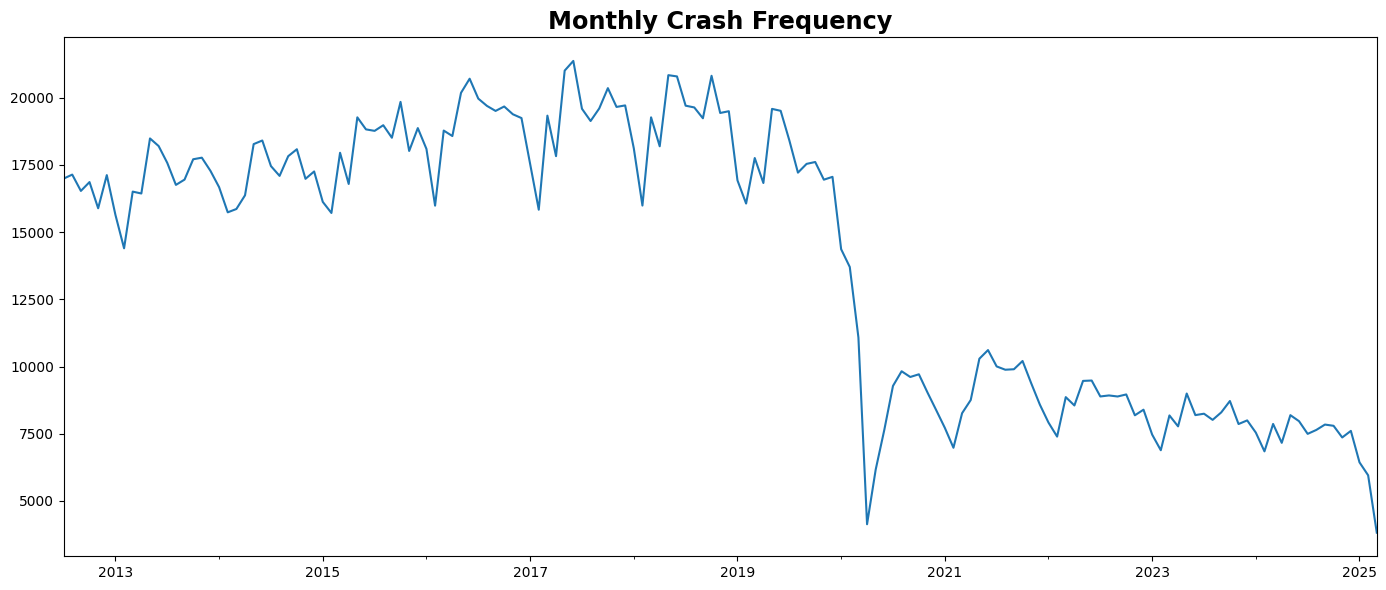

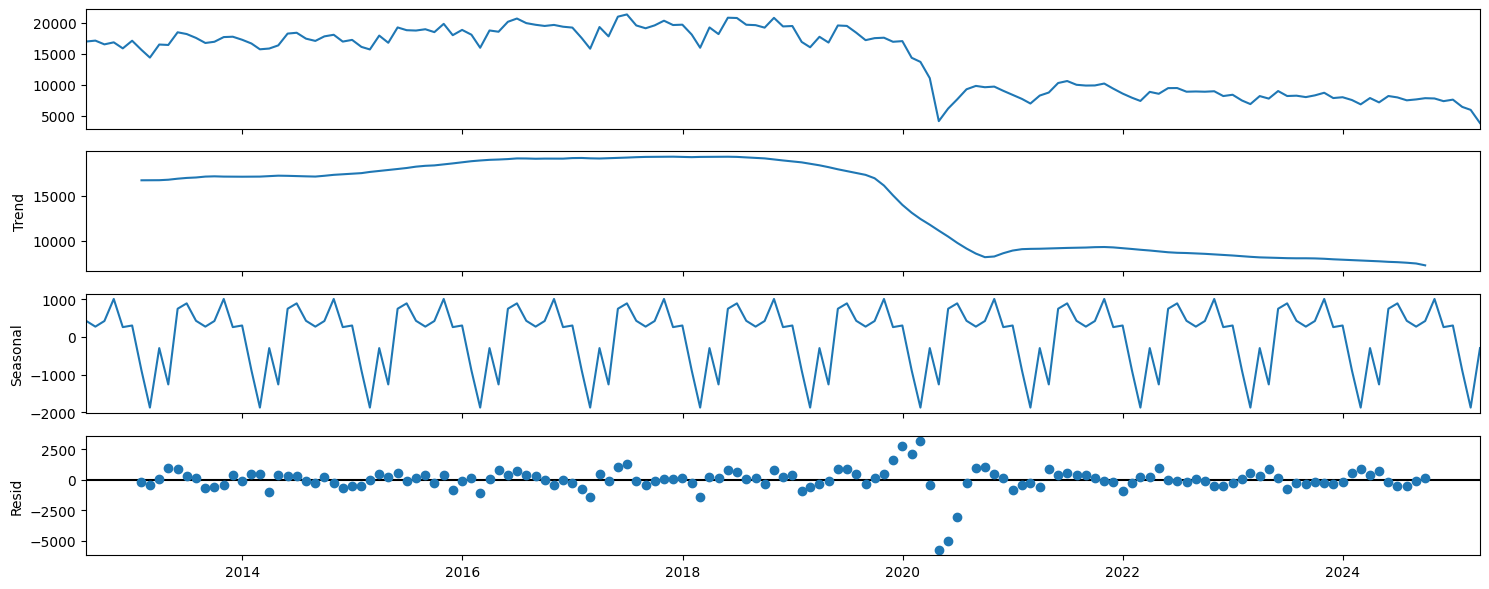

Results of Dickey-Fuller Test:
Test Statistic                  -0.091797
p-value                          0.950249
#Lags Used                      13.000000
Number of Observations Used    139.000000
Critical Value (1%)             -3.478294
Critical Value (5%)             -2.882568
Critical Value (10%)            -2.577983
dtype: float64
Conclusion: Series is non-stationary

Stationarity check on differenced series:
Results of Dickey-Fuller Test:
Test Statistic                  -3.100466
p-value                          0.026519
#Lags Used                      12.000000
Number of Observations Used    139.000000
Critical Value (1%)             -3.478294
Critical Value (5%)             -2.882568
Critical Value (10%)            -2.577983
dtype: float64
Conclusion: Series is stationary


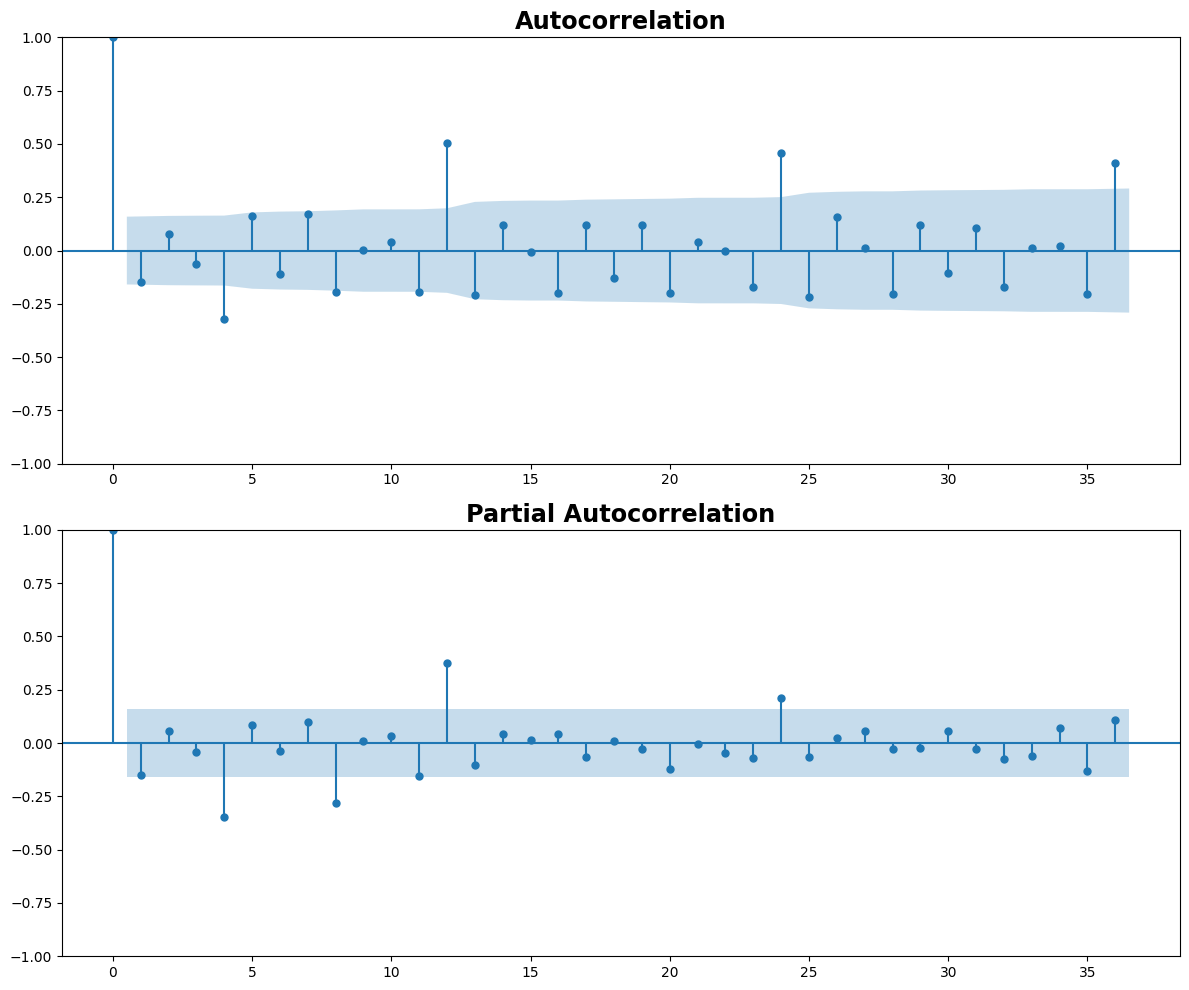

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  153
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1303.203
Date:                Fri, 18 Apr 2025   AIC                           2612.405
Time:                        05:01:15   BIC                           2621.477
Sample:                    07-31-2012   HQIC                          2616.091
                         - 03-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2392      0.578     -0.414      0.679      -1.371       0.893
ma.L1          0.1434      0.588      0.244      0.807      -1.009       1.296
sigma2      1.654e+06   1.08e+05     15.321      0.0

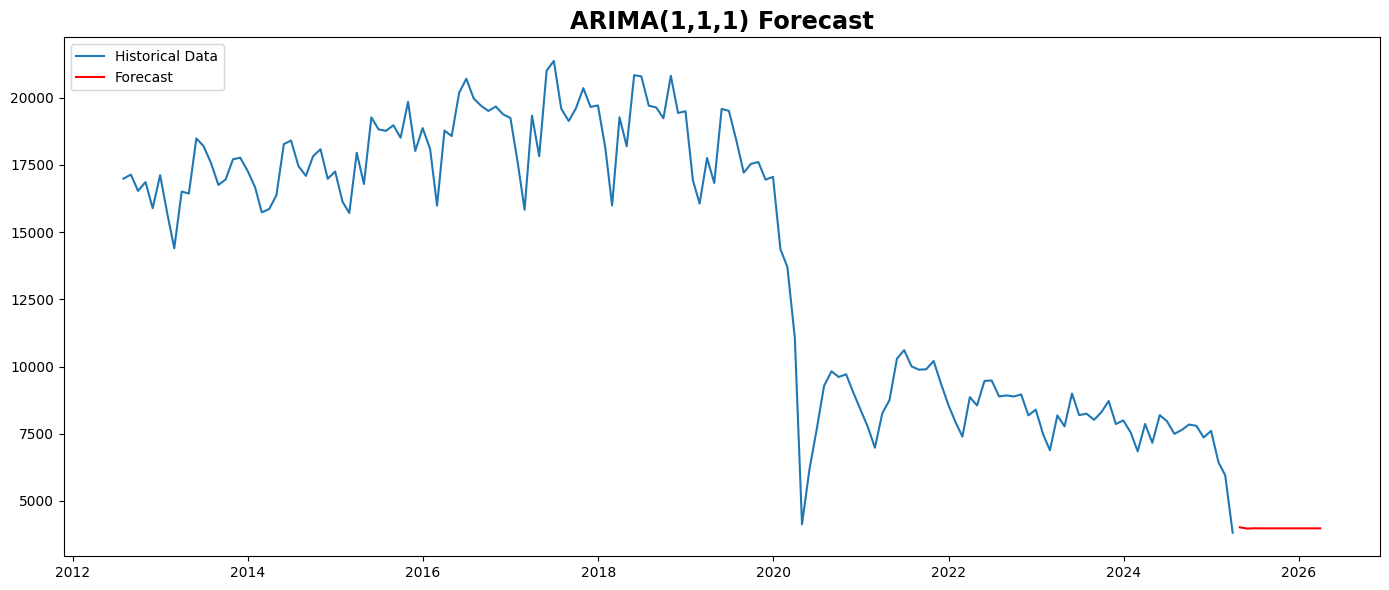

Mean Squared Error: 2455573.97
Root Mean Squared Error: 1567.03
Mean Absolute Error: 1230.08


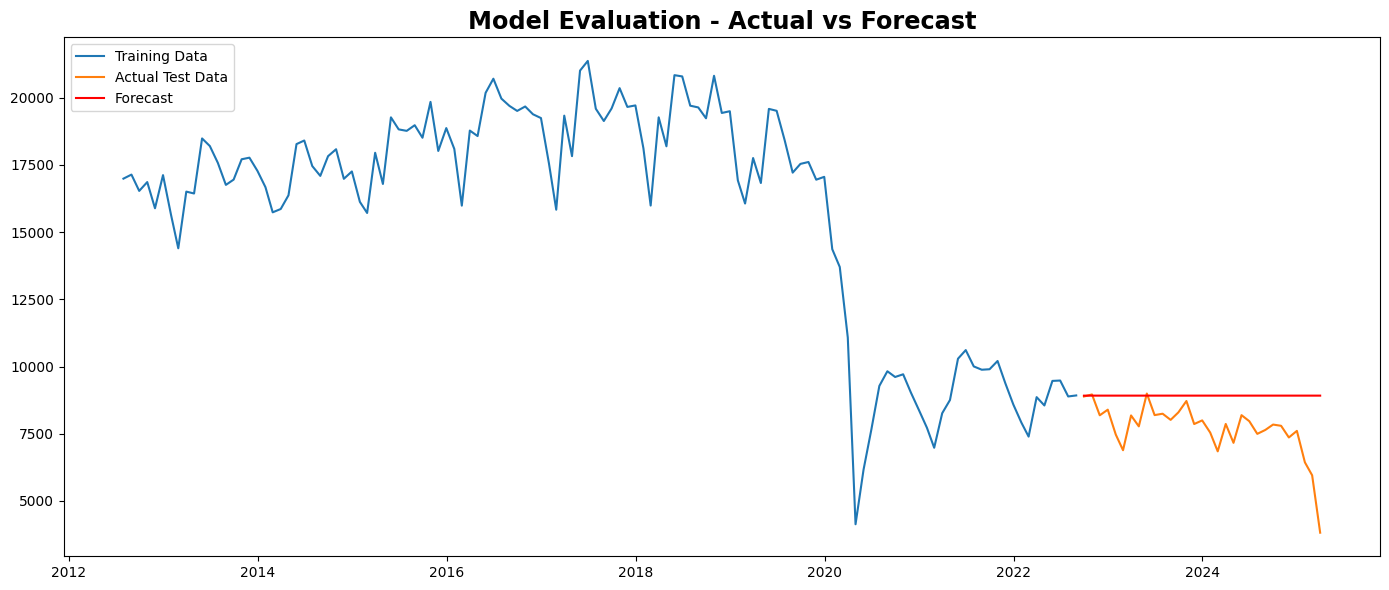

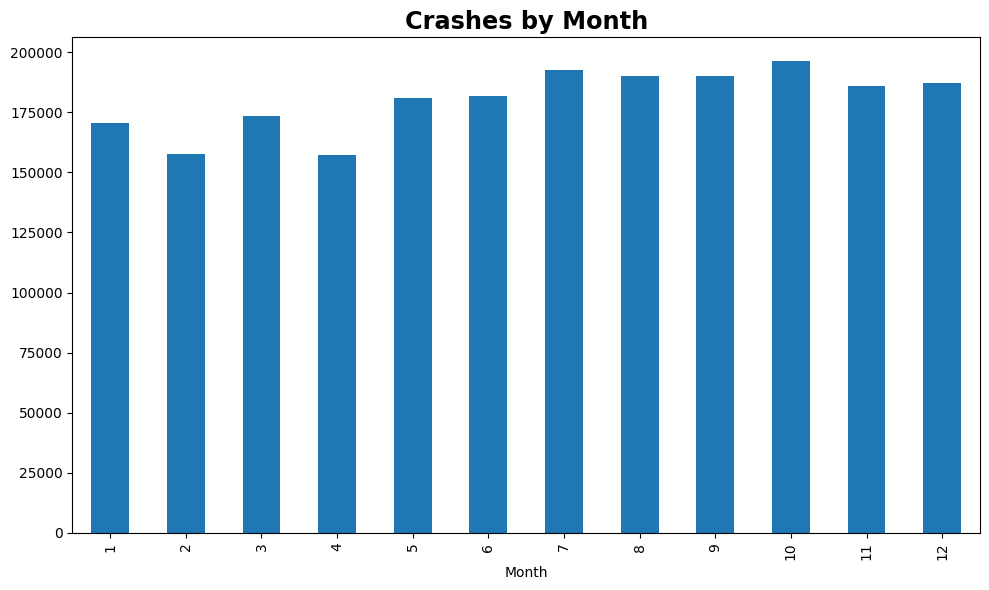

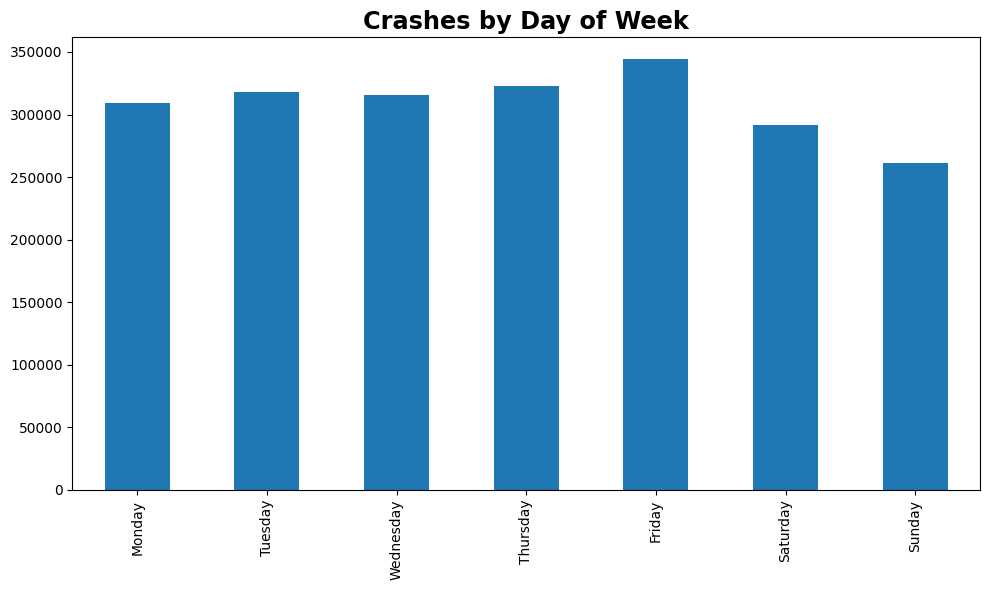

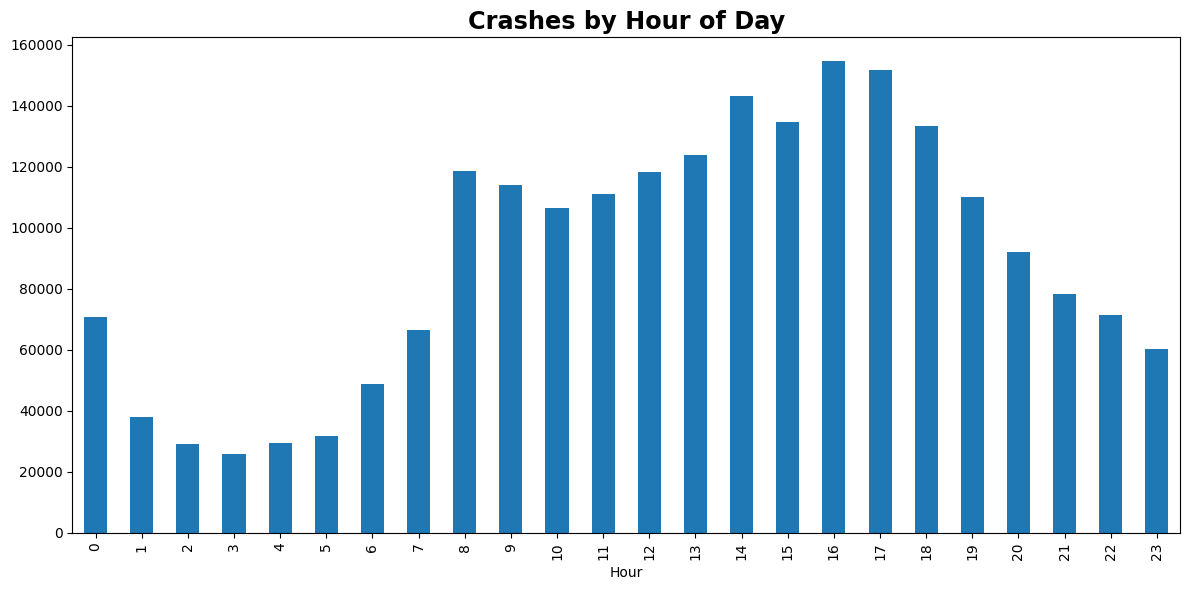

ARIMA(0,0,0) RMSE=8143.267
ARIMA(0,0,1) RMSE=8068.103
ARIMA(0,0,2) RMSE=8026.652
ARIMA(0,1,0) RMSE=1572.405
ARIMA(0,1,1) RMSE=1573.135
ARIMA(0,1,2) RMSE=1563.705
ARIMA(1,0,0) RMSE=5287.993
ARIMA(1,0,1) RMSE=4791.593
ARIMA(1,0,2) RMSE=5704.923
ARIMA(1,1,0) RMSE=1570.063
ARIMA(1,1,1) RMSE=1567.027
ARIMA(1,1,2) RMSE=1560.475
ARIMA(2,0,0) RMSE=4787.392
ARIMA(2,0,1) RMSE=4851.659
ARIMA(2,0,2) RMSE=3921.204
ARIMA(2,1,0) RMSE=1564.975
ARIMA(2,1,1) RMSE=1548.502
ARIMA(2,1,2) RMSE=1667.277
Best ARIMA(2, 1, 1) RMSE=1548.502


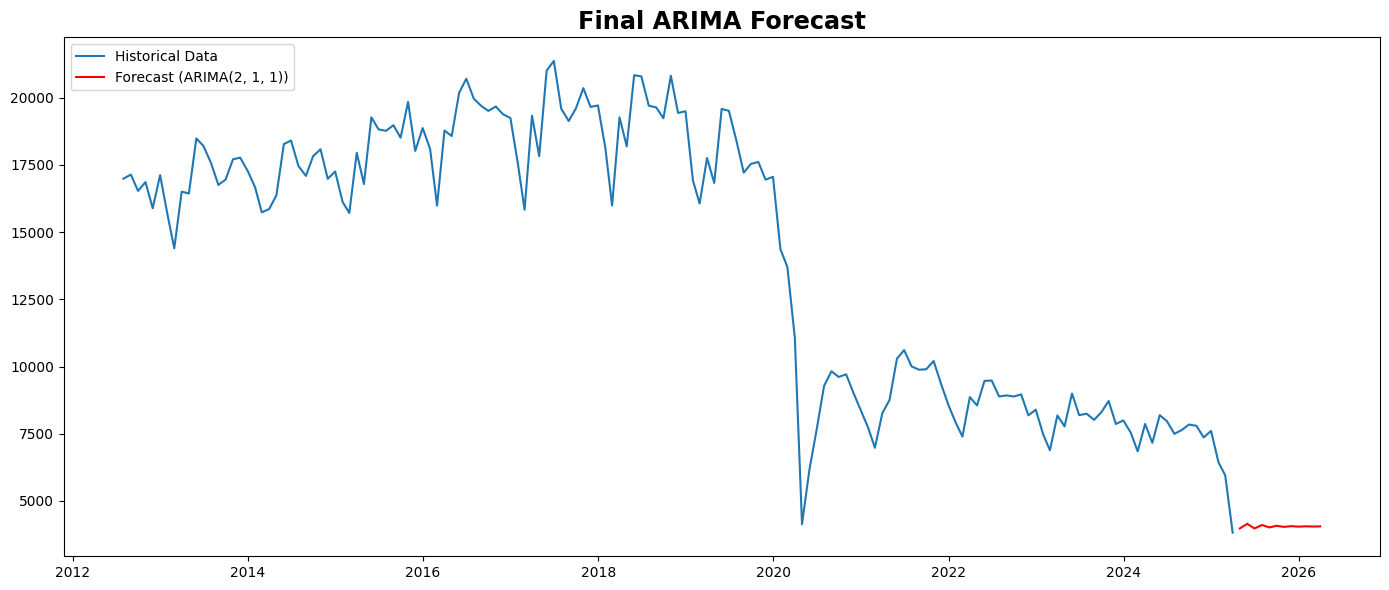

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# For reproducibility
np.random.seed(2026)


# 1. Data Preprocessing
# Convert crash date to datetime format
data['CRASH DATE'] = pd.to_datetime(data['CRASH DATE'])

# Create time-based features
data['Year'] = data['CRASH DATE'].dt.year
data['Month'] = data['CRASH DATE'].dt.month
data['Day'] = data['CRASH DATE'].dt.day
data['Weekday'] = data['CRASH DATE'].dt.dayofweek

# Extract hour from CRASH TIME (assuming format like "2:39" or "11:45")
def extract_hour(time_str):
    try:
        if pd.isna(time_str):
            return np.nan
        parts = time_str.split(':')
        return int(parts[0])
    except:
        return np.nan

data['Hour'] = data['CRASH TIME'].apply(extract_hour)

# 2. Create daily time series for crash frequency
daily_crashes = data.groupby('CRASH DATE').size()
daily_crashes.index = pd.DatetimeIndex(daily_crashes.index)
daily_crashes = daily_crashes.sort_index()

# Fill in missing dates with zero crashes
all_dates = pd.date_range(start=daily_crashes.index.min(), end=daily_crashes.index.max())
daily_crashes = daily_crashes.reindex(all_dates, fill_value=0)

# Create monthly time series
monthly_crashes = daily_crashes.resample('M').sum()

# 3. Exploratory Analysis
plt.figure(figsize=(14, 6))
daily_crashes.plot(title='Daily Crash Frequency')
plt.tight_layout()
plt.savefig('daily_crashes.png')
plt.show()
plt.close()

plt.figure(figsize=(14, 6))
monthly_crashes.plot(title='Monthly Crash Frequency')
plt.tight_layout()
plt.savefig('monthly_crashes.png')
plt.show()
plt.close()

# 4. Time Series Decomposition (using monthly data for clearer patterns)
decomposition = seasonal_decompose(monthly_crashes, model='additive', period=12)
fig = decomposition.plot()
plt.tight_layout()
plt.savefig('decomposition.png')
plt.show()
plt.close()

# 5. Check for stationarity using ADF test
def check_stationarity(timeseries):
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

    # Interpret results
    if dftest[1] <= 0.05:
        print("Conclusion: Series is stationary")
        return True
    else:
        print("Conclusion: Series is non-stationary")
        return False

is_stationary = check_stationarity(monthly_crashes)

# 6. If non-stationary, difference the series
if not is_stationary:
    differenced = monthly_crashes.diff().dropna()
    plt.figure(figsize=(14, 6))
    differenced.plot(title='Differenced Monthly Crashes')
    plt.tight_layout()
    plt.savefig('differenced.png')
    plt.close()

    print("\nStationarity check on differenced series:")
    is_diff_stationary = check_stationarity(differenced)
else:
    differenced = monthly_crashes

# 7. ACF and PACF plots to identify ARIMA parameters
plt.figure(figsize=(12, 10))
plt.subplot(211)
plot_acf(differenced, ax=plt.gca(), lags=36)
plt.subplot(212)
plot_pacf(differenced, ax=plt.gca(), lags=36)
plt.tight_layout()
plt.savefig('acf_pacf.png')
plt.show()
plt.close()

# 8. Fit ARIMA model
# Based on ACF/PACF plots, choose appropriate p, d, q values
# If the original series was non-stationary and differencing made it stationary, d=1
# Otherwise d=0
d = 1 if not is_stationary else 0

# p and q would be chosen based on PACF and ACF plots
# For now, let's start with p=1, q=1
p, q = 1, 1

# Fit ARIMA model
model = ARIMA(monthly_crashes, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

# 9. Forecast
forecast_steps = 12  # Forecast for next 12 months
forecast = model_fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=monthly_crashes.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
forecast_series = pd.Series(forecast, index=forecast_index)

# 10. Plot original data with forecast
plt.figure(figsize=(14, 6))
plt.plot(monthly_crashes, label='Historical Data')
plt.plot(forecast_series, label='Forecast', color='red')
plt.title(f'ARIMA({p},{d},{q}) Forecast')
plt.legend()
plt.tight_layout()
plt.savefig('forecast.png')
plt.show()
plt.close()

# 11. Evaluate model performance on a test set
# Split data into train and test sets
train_size = int(len(monthly_crashes) * 0.8)
train, test = monthly_crashes[:train_size], monthly_crashes[train_size:]

# Fit model on training data
model_eval = ARIMA(train, order=(p, d, q))
model_fit_eval = model_eval.fit()

# Forecast for the test period
forecast_test = model_fit_eval.forecast(steps=len(test))
forecast_test_series = pd.Series(forecast_test, index=test.index)

# Calculate error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test, forecast_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, forecast_test)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Test Data')
plt.plot(forecast_test_series, label='Forecast', color='red')
plt.title('Model Evaluation - Actual vs Forecast')
plt.legend()
plt.tight_layout()
plt.savefig('model_evaluation.png')
plt.show()
plt.close()

# 12. Feature-based analysis - Optional extra insights
# Monthly patterns
monthly_pattern = data.groupby('Month').size()
plt.figure(figsize=(10, 6))
monthly_pattern.plot(kind='bar', title='Crashes by Month')
plt.tight_layout()
plt.savefig('monthly_pattern.png')
plt.show()
plt.close()

# Day of week patterns
weekday_pattern = data.groupby('Weekday').size()
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_pattern.index = weekday_names
plt.figure(figsize=(10, 6))
weekday_pattern.plot(kind='bar', title='Crashes by Day of Week')
plt.tight_layout()
plt.savefig('weekday_pattern.png')
plt.show()
plt.close()

# Hour of day patterns
hourly_pattern = data.groupby('Hour').size()
plt.figure(figsize=(12, 6))
hourly_pattern.plot(kind='bar', title='Crashes by Hour of Day')
plt.tight_layout()
plt.savefig('hourly_pattern.png')
plt.show()
plt.close()

# 13. Grid search for optimal ARIMA parameters (p, d, q)
def evaluate_arima_model(X, arima_order):
    # Prepare training dataset
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]

    # Fit model
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=len(test))

    # Calculate error
    rmse = np.sqrt(mean_squared_error(test, forecast))
    return rmse

# Define range of parameters
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

best_score, best_order = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                rmse = evaluate_arima_model(monthly_crashes, (p, d, q))
                if rmse < best_score:
                    best_score, best_order = rmse, (p, d, q)
                print(f'ARIMA({p},{d},{q}) RMSE={rmse:.3f}')
            except:
                continue

print(f'Best ARIMA{best_order} RMSE={best_score:.3f}')

# 14. Fit the best model and generate final forecast
final_model = ARIMA(monthly_crashes, order=best_order)
final_model_fit = final_model.fit()

# Forecast for the next 12 months
final_forecast = final_model_fit.forecast(steps=12)
final_forecast_index = pd.date_range(start=monthly_crashes.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
final_forecast_series = pd.Series(final_forecast, index=final_forecast_index)

# Plot final results
plt.figure(figsize=(14, 6))
plt.plot(monthly_crashes, label='Historical Data')
plt.plot(final_forecast_series, label=f'Forecast (ARIMA{best_order})', color='red')
plt.title('Final ARIMA Forecast')
plt.legend()
plt.tight_layout()
plt.savefig('final_forecast.png')
plt.show()
plt.close()


As shown above, the number of crashes has gone down since 2020, COVID-19 prevalence might be significant to the result. Moreover, the Arima prediction seems to show that the trend of crashes might continue to slow down in the city of New York.

### Conclusion

The approach in this analysis involved training and evaluating three different machine learning models—Decision Tree, Logistic Regression, and Gaussian Naive Bayes—on a large dataset containing crash-related features. The dataset was split into a training set with 1,730,689 samples and a test set of 432,673 samples. The models were trained with hyperparameter tuning using GridSearchCV to find the best configurations, particularly for Logistic Regression, where the best parameters were identified with an F1 score of 0.9704. This step ensured that the models were optimized for better performance before evaluation.

The models were then evaluated using 5-fold cross-validation, with results showing consistently high accuracy and F1 scores across all models (around 98%). However, there were notable differences in their AUC-ROC scores, where Logistic Regression outperformed the other models with an AUC of 0.616, compared to 0.544 for the Decision Tree and 0.612 for Gaussian Naive Bayes. The models were retrained on the full training set and tested on the unseen test data, resulting in identical performance metrics for accuracy and F1 score. The AUC-ROC score for Logistic Regression remained the highest, reinforcing its strength in distinguishing between the classes.

In terms of feature importance, the most critical features for all models were related to time and date, such as YEAR, HOUR, and MONTH, followed by day of the week and time period. Despite the high accuracy and F1 scores, the models struggled with the minority class (label '1'), which had a precision and recall of zero. This suggests that the models are biased toward predicting the majority class (label '0'), and while they perform well in terms of overall accuracy, they may not be fully effective in predicting rare events like serious crashes. The classification reports further emphasized this imbalance, with the weighted averages showing strong performance but the macro averages indicating a substantial discrepancy between class predictions.

Lastly, the Arima model evaluation results are as follows: the Mean Squared Error (MSE) is 2,455,573.97, indicating large errors in the predictions, while the Root Mean Squared Error (RMSE) is 1,567.03, reflecting the magnitude of average errors. The Mean Absolute Error (MAE) is 1,230.08, signifying the average absolute deviation from the actual values. Despite these metrics showing relatively high errors, the Ljung-Box test (p-value = 0.51) suggests that there is no significant autocorrelation in the residuals, which implies the model has captured the time-dependent structure of the data adequately. However, the Jarque-Bera test indicates a problem with the residuals' normality, and the presence of heteroskedasticity (with p-value 0.01) suggests that the error variance may change over time. These results highlight that while the model captures some temporal dependencies, there may be issues related to the distribution of errors and variability, indicating room for model improvement.